<a href="https://colab.research.google.com/github/nahumsa/DM-Reconstruction/blob/master/Reconstruct%20DM_entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconstruction of a density matrix

### Import dependencies for Google Colab

In [0]:
! git clone https://github.com/nahumsa/DM-Reconstruction

In [0]:
!pip install qutip

In [0]:
% cd DM-Reconstruction/

##Import Dependencies

In [0]:
try:
  %tensorflow_version 2.x

except Exception:
  pass
  
import tensorflow as tf

#Set Random Seed for reproduction
tf.random.set_seed(1234)

# Remove warnings
import logging
logging.getLogger('tensorflow').disabled = True

#Use this to not need to initialize tensors outside session
tf.config.experimental_run_functions_eagerly(True)

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import qutip
from tqdm.notebook import tqdm

## Creating dataset

In [0]:
from Utils.Dataset import create_dataset

samples_train = 5000
states_train, measurements_train, labels_train = create_dataset(samples_train)

samples_test = 3000
states_test, measurements_test, labels_test = create_dataset(samples_test)

In [0]:
from Utils.Dataset import create_x

#Transforming in an np.array
X_train = np.array(create_x(measurements_train))
Y_train = np.array(labels_train)

X_test = np.array(create_x(measurements_test))
Y_test = np.array(labels_test)

#print(f"Shape of the Training: \n X: {X_train.shape}")

# Models

## Using Trace distance as a loss function

In [0]:
from Models.EVAE import EntropyVAE

ZDIM = 20
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 32

vae = EntropyVAE(original_dim=input_dim,
               intermediate_dim=hidden_dims,
               latent_dim=ZDIM)

# Optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer=optimizer)

# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)

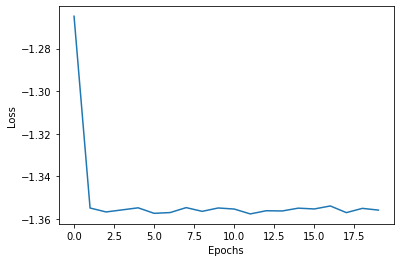

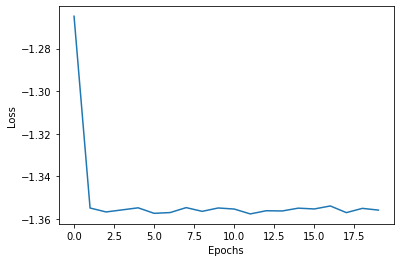

In [45]:
from Utils.Plotter import PeriodicPlotter

r_loss = 1.
beta = 1e-4
epochs = 20

# Periodic Plotter for loss
plotter = PeriodicPlotter(sec=5, xlabel='Epochs', ylabel='Loss')

loss_epochs = vae.training(dataset, epochs, r_loss, beta, Plotter=plotter)

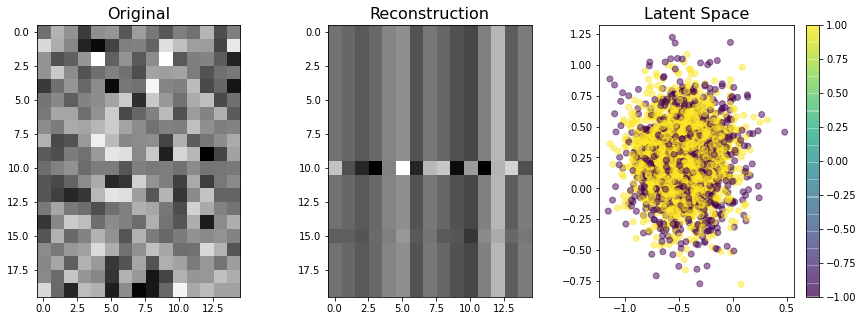

In [46]:
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1, 4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


ax1.imshow((X_train[0:20]), cmap="gray")
ax1.set_title('Original', size=16)

ax2.imshow(vae.predict(X_train[0:20]), cmap="gray")
ax2.set_title('Reconstruction', size=16)

_, _, z = vae.encoder(X_test)
z = z.numpy()

ax3 = fig.add_subplot(gs[0, 2])
ims = ax3.scatter(z[:,0], z[:,1], alpha=0.5, c=Y_test)
ax3.set_title('Latent Space', size=16)
#ax3.set_ylim(-100,100)
#ax3.set_xlim(-3,3)
plt.colorbar(ims, ax=ax3)

#ax4 = fig.add_subplot(gs[0, 3])
#ax4.hist(z)

plt.show()